In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from tableone import TableOne, load_dataset
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from imblearn.under_sampling import RandomUnderSampler

In [ ]:
def is_binary(df_, nums):
    df = df_.copy()
    variables = []
    for var in nums:
        flag = True
        unique = df_[var].unique()
        for value in unique:
            if value not in [0, 1, np.nan, 0.0, 1.0]:
                flag = False
        if flag == True:
            variables.append(var)
    return variables

def breakdown_vars(df, off_binary=False):
    """
    This function allow us categorize accodign to numerical or not
    """
    binaries = is_binary(df, df.columns)
    categorial = []
    nonormal = []
    normal = []
    for t in df.columns:
        if off_binary == False:
          if (df[t].dtypes.name=="object" or df[t].dtypes.name=='category') and  t not in binaries:
            categorial.append(t)
        else:
           if (df[t].dtypes.name=="object" or df[t].dtypes.name=='category'):
            categorial.append(t)
        if (df[t].dtypes=="int64" or df[t].dtypes=="float64") and t not in binaries:
                n,p = stats.shapiro(df[t])
                if p<0.05:
                    nonormal.append(t)
                else:
                    normal.append(t)
    if off_binary == False:
      return categorial, binaries, nonormal, normal
    else:
      return categorial, nonormal, normal

In [ ]:
url='https://raw.githubusercontent.com/4GeeksAcademy/decision-tree-project-tutorial/main/diabetes.csv'

In [ ]:
df=pd.read_csv(url)
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [ ]:
X= df.drop(columns='Outcome').copy()
y= df['Outcome']

In [ ]:
for col in X.columns:
  mean=df[col].mean()
  std=df[col].std()
  df[col]=(df[col]-mean)/std

In [ ]:
cat, nonormal, normal = breakdown_vars(df, off_binary=True)

In [ ]:
mytable=TableOne(df, categorical=cat, nonnormal=nonormal, groupby='Outcome', pval=True)
print(mytable)

                                          Grouped by Outcome                                                           
                                                     Missing          Overall                0                1 P-Value
n                                                                         768              500              268        
Pregnancies, median [Q1,Q3]                                0  -0.3 [-0.8,0.6]  -0.5 [-0.8,0.3]   0.0 [-0.6,1.2]  <0.001
Glucose, median [Q1,Q3]                                    0  -0.1 [-0.7,0.6]  -0.4 [-0.9,0.1]   0.6 [-0.1,1.4]  <0.001
BloodPressure, median [Q1,Q3]                              0   0.1 [-0.4,0.6]   0.0 [-0.4,0.5]   0.3 [-0.2,0.7]  <0.001
SkinThickness, median [Q1,Q3]                              0   0.2 [-1.3,0.7]   0.0 [-1.3,0.7]   0.4 [-1.3,1.0]   0.013
Insulin, median [Q1,Q3]                                    0  -0.4 [-0.7,0.4]  -0.4 [-0.7,0.2]  -0.7 [-0.7,0.8]   0.066
BMI, median [Q1,Q3]                     

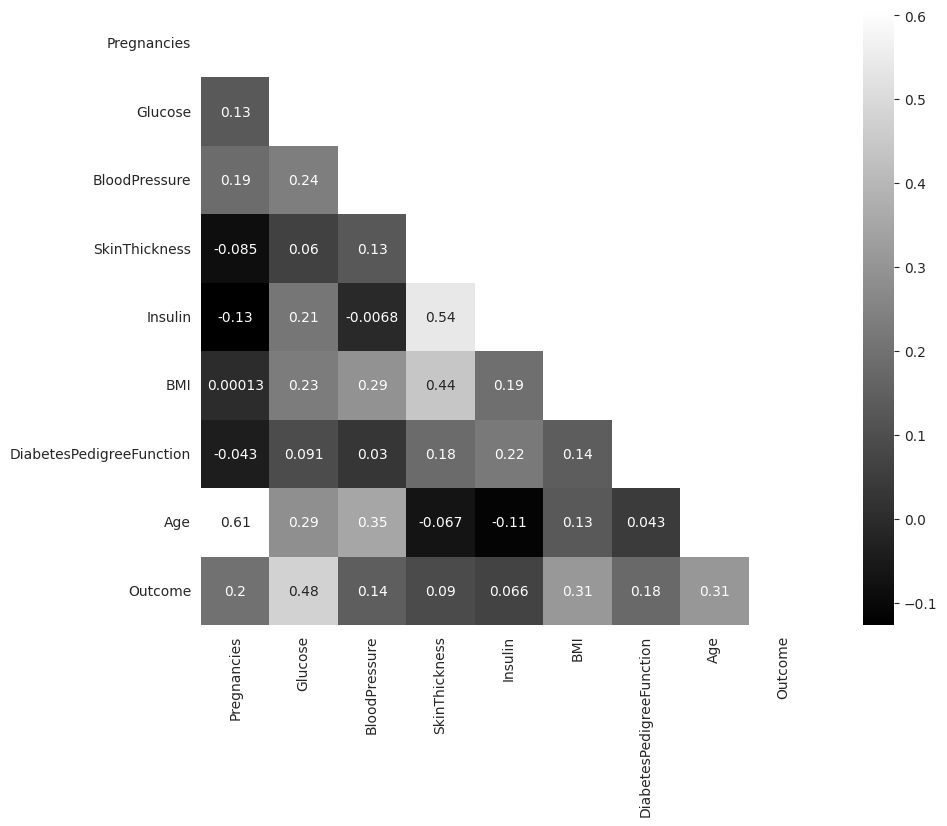

In [ ]:
corrMatrix=df.corr(method='spearman')
mask = np.zeros_like(corrMatrix)
mask[np.triu_indices_from(mask)]=True
with sns.axes_style('white'):
  f,ax =plt.subplots(figsize=(12,8))
  ax = sns.heatmap(corrMatrix, mask=mask, square=True, annot=True, cmap='gray')

In [ ]:
df2=pd.read_csv(url)

In [ ]:
X=df2.drop(columns='Outcome').copy()
y=df2['Outcome']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.20, shuffle=True, random_state=12,stratify=y)

In [ ]:
scaler=StandardScaler()

X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

In [ ]:
arbol=DecisionTreeClassifier(random_state=12)
preds=arbol.fit(X_train,y_train).predict(X_test)
print(classification_report(y_test,preds))

              precision    recall  f1-score   support

           0       0.83      0.81      0.82       100
           1       0.66      0.69      0.67        54

    accuracy                           0.77       154
   macro avg       0.74      0.75      0.75       154
weighted avg       0.77      0.77      0.77       154



In [ ]:
def grid_RandomForest(X_train, y_train):
  model = RandomForestClassifier(random_state=0)
  n_estimators = [100,500,1000]
  criterion = ['gini', 'entropy', 'log_loss']
  min_samples_split = [0.05, 0.1,]
  max_depth = [2,3,4]
  grid = dict(n_estimators = n_estimators, criterion = criterion,
              min_samples_split = min_samples_split, max_depth = max_depth)
  cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)
  grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv,
                            scoring='f1',error_score='raise')
  grid_result = grid_search.fit(X_train, y_train)
  return  grid_result.best_estimator_

In [ ]:
rus = RandomUnderSampler(random_state=542)
X_train, y_train = rus.fit_resample(X_train, y_train)

In [ ]:
best_rfc=grid_RandomForest(X_train,y_train)
preds3=best_rfc.predict(X_test)
print(classification_report(y_test,preds3))

              precision    recall  f1-score   support

           0       0.88      0.81      0.84       100
           1       0.69      0.80      0.74        54

    accuracy                           0.81       154
   macro avg       0.79      0.80      0.79       154
weighted avg       0.81      0.81      0.81       154



In [ ]:
from pickle import dump

dump(model, open("../models/randomforest_stimator.sav", "wb"))